<a href="https://colab.research.google.com/github/dmswl0707/Algorithm_python/blob/main/BiLSTM%EC%9D%84_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EC%98%81%ED%99%94_%EB%A6%AC%EB%B7%B0_%EA%B0%90%EC%84%B1%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [244]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense,Flatten, Bidirectional,LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
!pip install konlpy
from konlpy.tag import Okt

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [245]:
train = '/content/drive/My Drive/Colab Notebooks/dataset/train.csv'
test = '/content/drive/My Drive/Colab Notebooks/dataset/test.csv'
sub = '/content/drive/My Drive/Colab Notebooks/dataset/sample_submission.csv'

df = pd.read_csv(train)
testset = pd.read_csv(test)
submission = pd.read_csv(sub)

df.head(3)

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1


In [246]:
df.shape

(5000, 3)

In [247]:
# 긍정 부정 간 레이블 간 100장 차이
df=df.drop(columns='id')
df.value_counts('label')

label
0    2564
1    2436
dtype: int64

In [248]:
df.isnull().sum()

document    0
label       0
dtype: int64

### 데이터 전처리
1. 정규 표현식 제거
2. 불용어 제거
3. 토큰화
4. 인코딩 작업



In [249]:
# 정규 표현식 제거
df['document']=df['document'].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]", "")
df.head(3)

,document,label
0,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯,1
2,괜찮은 음악영화가 또 나왔군요 따뜻한 겨울이 될 것 같아요,1


In [250]:
# 불용어 제거
# 불용어를 직접 정의할수도 있고, set(stop_words.split(" "))을 사용하기도 함

stop_words = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']
x_train = []
x_test = []
okt = Okt()

def remove_stopwords(list_, df):
  for sent in tqdm(df):
    token = okt.morphs(sent, stem=True)
    rem_stopwords = [word for word in token if not word in stop_words]
    list_.append(rem_stopwords)

In [251]:
# train set 가공
remove_stopwords(x_train, df['document'])

# test set 가공
remove_stopwords(x_test, testset['document'])

100%|██████████| 5000/5000 [00:11<00:00, 421.55it/s]


In [252]:
# 토큰화 작업

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

vocab_size =len(tokenizer.word_index) #6648

In [253]:
# 정수 인코딩 작업

tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(x_train)

x_train=tokenizer.texts_to_sequences(x_train)
x_test=tokenizer.texts_to_sequences(x_test)

In [254]:
# 토큰화된 단어의 중복 빈도수 확인
#print(tokenizer.word_counts)

In [255]:
# 토큰화된 단어의 중복 빈도수가 높을수록 인덱스 번호가 낮음
#print(tokenizer.word_index)

In [256]:
# 패딩의 길이 임의로 설정
x_train=pad_sequences(x_train, maxlen=15)
x_test=pad_sequences(x_test, maxlen=15)

y_train=df['label']

### 신경망 모델링

In [257]:
model = Sequential()
model.add(Embedding(num_words, 1500))
model.add(Bidirectional(LSTM(500, activation='elu', recurrent_dropout=0.2)))
model.add(Dense(600))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 1500)        9975000   
                                                                 
 bidirectional_10 (Bidirecti  (None, 1000)             8004000   
 onal)                                                           
                                                                 
 dense_20 (Dense)            (None, 600)               600600    
                                                                 
 flatten_10 (Flatten)        (None, 600)               0         
                                                                 
 dense_21 (Dense)            (None, 1)                 601       
                                                                 
Total params: 18,580,201
Trainable params: 18,580,201
Non-trainable params: 0
_________________________________________

### 신경망 학습

In [258]:
EarlyStop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
Checkpoint = ModelCheckpoint('checkpoint.h5', monitor='val_acc', mode='max', save_best_only=True)
scheduler =  ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=30, callbacks=[EarlyStop, Checkpoint, scheduler], batch_size=256, validation_split=0.2)

Epoch 1/30
16/16 [==============================] - 7s 199ms/step - loss: 0.6428 - acc: 0.6837 - val_loss: 0.4382 - val_acc: 0.7900 - lr: 0.0010
Epoch 2/30
16/16 [==============================] - 3s 165ms/step - loss: 0.2680 - acc: 0.8978 - val_loss: 0.3705 - val_acc: 0.8500 - lr: 0.0010
Epoch 3/30
16/16 [==============================] - 2s 135ms/step - loss: 0.0980 - acc: 0.9632 - val_loss: 0.5388 - val_acc: 0.8230 - lr: 0.0010
Epoch 4/30
16/16 [==============================] - 2s 135ms/step - loss: 0.0408 - acc: 0.9862 - val_loss: 0.5402 - val_acc: 0.8440 - lr: 0.0010
Epoch 5/30
16/16 [==============================] - 2s 131ms/step - loss: 0.0159 - acc: 0.9960 - val_loss: 0.5519 - val_acc: 0.8440 - lr: 2.0000e-04
Epoch 6/30
16/16 [==============================] - 2s 133ms/step - loss: 0.0108 - acc: 0.9977 - val_loss: 0.5759 - val_acc: 0.8470 - lr: 2.0000e-04
Epoch 7/30
16/16 [==============================] - 2s 133ms/step - loss: 0.0084 - acc: 0.9990 - val_loss: 0.5874 - val_ac

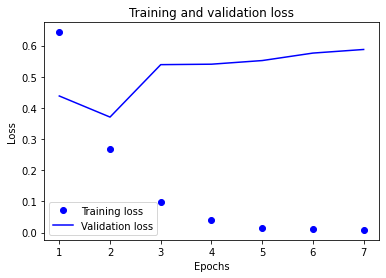

In [259]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

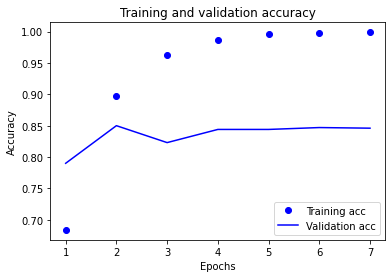

In [260]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

fig2 = plt.gcf()

plt.draw()
fig2.savefig('fig2.png', dpi=100)

### 신경망 추론

In [261]:
inference = load_model('checkpoint.h5')
y_pred = inference.predict(x_test)

In [262]:
def submission_ypred():
    for i in range(len(y_pred)):
        if y_pred[i] < 0.5 :
            y_pred[i] = 0
        else:
            y_pred[i] = 1
    
submission_ypred()
submission['label']=y_pred
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/dataset/BidirectionalLSTM.csv', index=False)